### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast

Possible TODOs:
- after writing summaries, could parallelize some stuff, topic analysis, ratings
- could also add tools to check format
- rewrite using an critic-refine flow, although one rewrite does an OK job
- do more evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_const import (
                        REWRITE_SYSTEM_PROMPT, REWRITE_USER_PROMPT,
                        SCREENSHOT_DIR, SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (Agent, AgentState, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

In [ ]:
before_date = None
# before_date = '2025-04-26 08:00'
do_download = True

# low, medium, high models
ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1-mini', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=4)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state,
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-04-28 17:36:02,729 - AInewsbot - INFO - Initializing with before_date=2025-04-28 08:00, do_download=False, thread_id=f18b5882b8b2428e96c1da418a3be59a


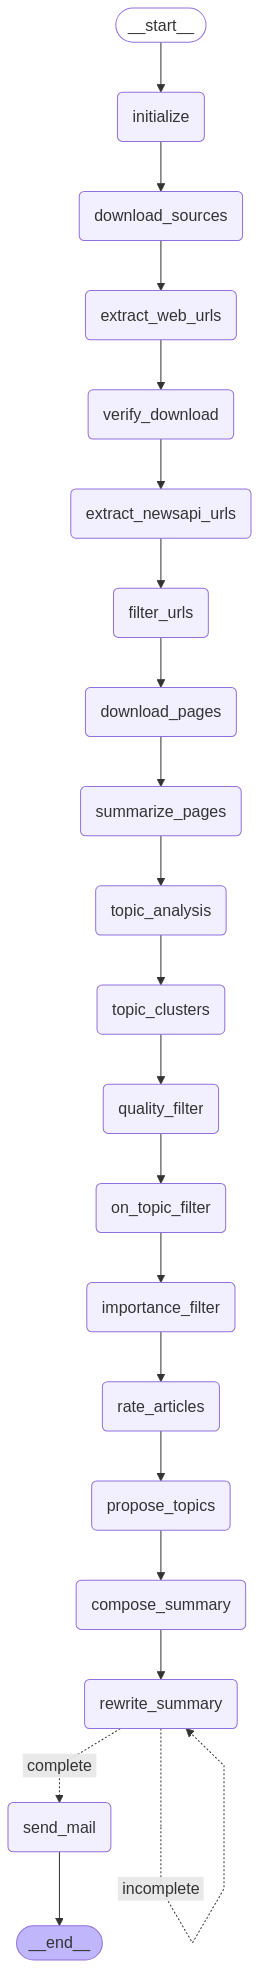

In [4]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

# before_date = None
before_date = '2025-04-28 08:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=4)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [5]:
lg_state = lg_agent.initialize_config(lg_state)


2025-04-28 17:36:03,597 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-04-28 17:36:03,599 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-04-28 17:36:03,599 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-04-28 17:36:03,600 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-04-28 17:36:03,600 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-04-28 17:36:03,601 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly_AI.html
2025-04-28 17:36:03,601 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

In [6]:
lg_state = lg_agent.download_sources(lg_state)


2025-04-28 17:36:04,259 - AInewsbot - INFO - Web fetch disabled, using existing files in htmldata
2025-04-28 17:36:04,261 - AInewsbot - INFO - Found 16 previously downloaded files
2025-04-28 17:36:04,261 - AInewsbot - INFO - htmldata/Techmeme.html
2025-04-28 17:36:04,262 - AInewsbot - INFO - htmldata/Hacker_News_1.html
2025-04-28 17:36:04,262 - AInewsbot - INFO - htmldata/Reddit.html
2025-04-28 17:36:04,262 - AInewsbot - INFO - htmldata/HackerNoon.html
2025-04-28 17:36:04,263 - AInewsbot - INFO - htmldata/VentureBeat.html
2025-04-28 17:36:04,263 - AInewsbot - INFO - htmldata/Feedly_AI.html
2025-04-28 17:36:04,264 - AInewsbot - INFO - htmldata/The_Register.html
2025-04-28 17:36:04,264 - AInewsbot - INFO - htmldata/FT.html
2025-04-28 17:36:04,264 - AInewsbot - INFO - htmldata/Business_Insider.html
2025-04-28 17:36:04,265 - AInewsbot - INFO - htmldata/Washington_Post.html
2025-04-28 17:36:04,265 - AInewsbot - INFO - htmldata/New_York_Times.html
2025-04-28 17:36:04,265 - AInewsbot - INFO -

In [7]:
lg_state = lg_agent.extract_web_urls(lg_state)


2025-04-28 17:36:04,919 - AInewsbot - INFO - Parsing html files
2025-04-28 17:36:04,922 - AInewsbot - INFO - Ars Technica -> htmldata/Ars_Technica.html
2025-04-28 17:36:04,961 - AInewsbot - INFO - parse_file - found 169 raw links
2025-04-28 17:36:04,963 - AInewsbot - INFO - parse_file - found 36 filtered links
2025-04-28 17:36:04,963 - AInewsbot - INFO - 36 links found
2025-04-28 17:36:04,964 - AInewsbot - INFO - Bloomberg -> htmldata/Bloomberg.html
2025-04-28 17:36:05,163 - AInewsbot - INFO - parse_file - found 245 raw links
2025-04-28 17:36:05,166 - AInewsbot - INFO - parse_file - found 37 filtered links
2025-04-28 17:36:05,167 - AInewsbot - INFO - 37 links found
2025-04-28 17:36:05,167 - AInewsbot - INFO - Business Insider -> htmldata/Business_Insider.html
2025-04-28 17:36:05,185 - AInewsbot - INFO - parse_file - found 211 raw links
2025-04-28 17:36:05,187 - AInewsbot - INFO - parse_file - found 21 filtered links
2025-04-28 17:36:05,188 - AInewsbot - INFO - 21 links found
2025-04-28

In [8]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 16


,id
src,
Ars Technica,36
Bloomberg,32
Business Insider,21
FT,64
Feedly AI,30
Hacker News 1,25
Hacker News 2,23
HackerNoon,13
New York Times,29


number of missing sources 0


set()

In [9]:
lg_state = lg_agent.verify_download(lg_state)


2025-04-28 17:36:09,273 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


In [10]:
lg_state = lg_agent.extract_newsapi_urls(lg_state)


2025-04-28 17:36:13,197 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-04-27T17:36:13 from NewsAPI


In [11]:
# filter by headlines that we haven't seen and that look like AI
# we don't want to summarize all before filtering on headline
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


2025-04-28 17:36:14,954 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-04-28 08:00'
2025-04-28 17:36:15,490 - AInewsbot - INFO - URLs in orig_df: 797
2025-04-28 17:36:15,493 - AInewsbot - INFO - Existing URLs in DB: 251495
2025-04-28 17:36:15,556 - AInewsbot - INFO - New URLs in df filtered by URL: 198
2025-04-28 17:36:15,688 - AInewsbot - INFO - Existing src+title: 25
2025-04-28 17:36:15,689 - AInewsbot - INFO - New URLs in df filtered by src+title: 173
2025-04-28 17:36:15,704 - AInewsbot - INFO - Found 173 unique new headlines
2025-04-28 17:36:15,705 - AInewsbot - INFO - Found 173 unique cleaned new headlines
2025-04-28 17:36:19,468 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:36:23,160 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:36:23,166 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

,id
src,
Bloomberg,4
Business Insider,2
Feedly AI,26
Hacker News 1,6
Hacker News 2,2
HackerNoon,1
New York Times,1
NewsAPI,18
Reddit,5


In [12]:
lg_state = lg_agent.download_pages(lg_state)


2025-04-28 17:36:26,903 - AInewsbot - INFO - Queuing URLs for scraping
2025-04-28 17:36:26,911 - AInewsbot - INFO - Saving HTML files using async concurrency= 4
2025-04-28 17:36:27,178 - AInewsbot - INFO - Launching browser
2025-04-28 17:36:28,215 - AInewsbot - INFO - Launching workers
2025-04-28 17:36:28,215 - AInewsbot - INFO - Finishing and closing browser
2025-04-28 17:36:28,215 - AInewsbot - INFO - Launching worker
2025-04-28 17:36:28,216 - AInewsbot - INFO - from queue: 0, https://biztoc.com/x/27a5f8a075bc5990, 'Three Or Four Times Better': AI 'Godfather' Geoffrey Hinton Says AI Tutors Could Soon Outperform Humans And Make Degrees Obsolete
2025-04-28 17:36:28,216 - AInewsbot - INFO - fetch_url(https://biztoc.com/x/27a5f8a075bc5990)
2025-04-28 17:36:28,216 - AInewsbot - INFO - File already exists: htmlpages/Three_Or_Four_Times_Better___AI__Godfather__Geoffrey_Hinton_Says_AI_Tutors_Could_Soon_Outperform_Humans_And_Make_Degrees_Obsolete.html
2025-04-28 17:36:28,217 - AInewsbot - INF

2025-04-28 17:36:28,223 - AInewsbot - INFO - fetch_url(https://www.pymnts.com/news/investment-tracker/2025/anthropic-backed-goodfire-raises-50-million-to-access-ais-internal-thoughts/)
2025-04-28 17:36:28,223 - AInewsbot - INFO - File already exists: htmlpages/Anthropic-Backed_Goodfire_Raises__50_Million_to_Access_AIs_Internal_Thoughts.html
2025-04-28 17:36:28,223 - AInewsbot - INFO - from queue: 15, https://biztoc.com/x/70a9cecdbc6f0d22, Apple's AI Team Undergoes Major Restructuring Amidst Performance Concerns
2025-04-28 17:36:28,223 - AInewsbot - INFO - fetch_url(https://biztoc.com/x/70a9cecdbc6f0d22)
2025-04-28 17:36:28,224 - AInewsbot - INFO - File already exists: htmlpages/Apple_s_AI_Team_Undergoes_Major_Restructuring_Amidst_Performance_Concerns.html
2025-04-28 17:36:28,224 - AInewsbot - INFO - from queue: 16, https://venturebeat.com/ai/beyond-a2a-and-mcp-how-lokas-universal-agent-identity-layer-changes-the-game/, Beyond A2A and MCP: How LOKAs Universal Agent Identity Layer change

2025-04-28 17:36:28,231 - AInewsbot - INFO - fetch_url(https://techcrunch.com/2025/04/28/hugging-face-releases-a-3d-printed-robotic-arm-starting-at-100/)
2025-04-28 17:36:28,232 - AInewsbot - INFO - File already exists: htmlpages/Hugging_Face_releases_a_3D-printed_robotic_arm_starting_at__100.html
2025-04-28 17:36:28,232 - AInewsbot - INFO - from queue: 32, https://www.bloomberg.com/news/articles/2025-04-28/ibm-plans-to-invest-150-billion-in-us-over-next-five-years, IBM plans to invest $150B in the US over the next five years, including in R&D, to fuel the economy and accelerate its role as the global leader in computing
2025-04-28 17:36:28,232 - AInewsbot - INFO - fetch_url(https://www.bloomberg.com/news/articles/2025-04-28/ibm-plans-to-invest-150-billion-in-us-over-next-five-years)
2025-04-28 17:36:28,233 - AInewsbot - INFO - File already exists: htmlpages/IBM_plans_to_invest__150B_in_the_US_over_the_next_five_years__including_in_R_D__to_fuel_the_economy_and_accelerate_its_role_as_th

2025-04-28 17:36:28,238 - AInewsbot - INFO - fetch_url(https://fortune.com/9999/09/99/startup-ai-funding-starship-google-deepmind-airbus-veterans/)
2025-04-28 17:36:28,239 - AInewsbot - INFO - File already exists: htmlpages/P-1_AI__which_is_developing_an_AI-powered_engineering_agent_and_hopes_AI_can_eventually_design_complex_machines__emerges_from_stealth_with__23M_in_seed_funding.html
2025-04-28 17:36:28,239 - AInewsbot - INFO - from queue: 47, https://siliconangle.com/2025/04/28/palo-alto-networks-buys-protect-ai-reported-500m-debuts-new-cybersecurity-tools/, Palo Alto Networks buys Protect AI for reported $500M+, debuts new cybersecurity tools
2025-04-28 17:36:28,239 - AInewsbot - INFO - fetch_url(https://siliconangle.com/2025/04/28/palo-alto-networks-buys-protect-ai-reported-500m-debuts-new-cybersecurity-tools/)
2025-04-28 17:36:28,239 - AInewsbot - INFO - File already exists: htmlpages/Palo_Alto_Networks_buys_Protect_AI_for_reported__500M___debuts_new_cybersecurity_tools.html
2025

2025-04-28 17:36:28,246 - AInewsbot - INFO - from queue: 62, https://biztoc.com/x/b10436de22b3f657, There's 1 Top AI Stock Insiders Keep Selling. Here's Why Shares Could Plummet 50% in a Market Crash
2025-04-28 17:36:28,246 - AInewsbot - INFO - fetch_url(https://biztoc.com/x/b10436de22b3f657)
2025-04-28 17:36:28,247 - AInewsbot - INFO - File already exists: htmlpages/There_s_1_Top_AI_Stock_Insiders_Keep_Selling._Here_s_Why_Shares_Could_Plummet_50__in_a_Market_Crash.html
2025-04-28 17:36:28,247 - AInewsbot - INFO - from queue: 63, https://github.com/skyzh/tiny-llm, Tiny-LLM  a course of serving LLM on Apple Silicon for systems engineers
2025-04-28 17:36:28,247 - AInewsbot - INFO - fetch_url(https://github.com/skyzh/tiny-llm)
2025-04-28 17:36:28,247 - AInewsbot - INFO - File already exists: htmlpages/Tiny-LLM__a_course_of_serving_LLM_on_Apple_Silicon_for_systems_engineers.html
2025-04-28 17:36:28,247 - AInewsbot - INFO - from queue: 64, https://qz.com/trump-artificial-intelligence-expert

In [13]:
pd.DataFrame(lg_state["AIdf"])

,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path
0,0,https://biztoc.com/x/27a5f8a075bc5990,NewsAPI,'Three Or Four Times Better': AI 'Godfather' G...,True,https://biztoc.com/x/27a5f8a075bc5990,biztoc.com,biztoc.com,0,htmlpages/Three_Or_Four_Times_Better___AI__God...
1,1,https://venturebeat.com/ai/30-seconds-vs-3-the...,Feedly AI,30 seconds vs. 3: The d1 reasoning framework t...,True,https://venturebeat.com/ai/30-seconds-vs-3-the...,venturebeat.com,VentureBeat,1,htmlpages/30_seconds_vs._3__The_d1_reasoning_f...
2,2,https://aiagent.marktechpost.com/post/601-ai-a...,Feedly AI,601 AI Agent Use Cases: Insights from the Worl...,True,https://aiagent.marktechpost.com/post/601-ai-a...,aiagent.marktechpost.com,aiagent.marktechpost.com,0,htmlpages/601_AI_Agent_Use_Cases__Insights_fro...
3,3,https://thezvi.substack.com/p/gpt-4o-is-an-abs...,Techmeme,A deep dive on GPT-4o's tendency to give sycop...,True,https://thezvi.substack.com/p/gpt-4o-is-an-abs...,thezvi.substack.com,The Zvi,0,htmlpages/A_deep_dive_on_GPT-4o_s_tendency_to_...
4,4,https://www.zdnet.com/article/a-few-secretive-...,NewsAPI,A few secretive AI companies could crush free ...,True,https://www.zdnet.com/article/a-few-secretive-...,www.zdnet.com,ZDNet,2,htmlpages/A_few_secretive_AI_companies_could_c...
...,...,...,...,...,...,...,...,...,...,...
69,69,https://dailyhodl.com/2025/04/27/venture-capit...,NewsAPI,"Venture Capital Firm Invests ~$50,000,000 in S...",True,https://dailyhodl.com/2025/04/27/venture-capit...,dailyhodl.com,dailyhodl.com,0,htmlpages/Venture_Capital_Firm_Invests___50_00...
70,70,https://arxiv.org/abs/2309.16588,Hacker News 1,Vision Transformers Need Registers,True,https://arxiv.org/abs/2309.16588,arxiv.org,arXiv,1,htmlpages/Vision_Transformers_Need_Registers.html
71,71,https://www.forbes.com/sites/johnwerner/2025/0...,NewsAPI,Watching Beijings Spring Robot Race,True,https://www.forbes.com/sites/johnwerner/2025/0...,www.forbes.com,Forbes,1,htmlpages/Watching_Beijings_Spring_Robot_Race....
72,72,https://siliconangle.com/2025/04/28/writer-ann...,Feedly AI,Writer announces Palmyra X5 LLM with 1M-token ...,True,https://siliconangle.com/2025/04/28/writer-ann...,siliconangle.com,SiliconANGLE,2,htmlpages/Writer_announces_Palmyra_X5_LLM_with...


In [14]:
# summarize downloaded pages

lg_state = lg_agent.summarize_pages(lg_state)


2025-04-28 17:36:37,058 - AInewsbot - INFO - Starting summarize
2025-04-28 17:36:37,062 - AInewsbot - INFO - Fetching summaries for all articles
2025-04-28 17:36:37,080 - AInewsbot - INFO - clean_html - Page title: 'Three Or Four Times Better': AI 'Godfather' Geoffrey Hinton Says AI Tutors Could Soon Outperform Humans And Make Degrees Obsolete
Social card title: 'Three Or Four Times Better': AI 'Godfather' Geoffrey Hinton Says AI Tutors Could Soon Outperform Humans And Make Degrees Obsolete
Social card description: Artificial intelligence could soon do more than help with homework—it might replace traditional universities altogether. Geoffrey Hinton, known as the…

2025-04-28 17:36:37,215 - AInewsbot - INFO - Queuing 0: Page title: 'Three Or Four Times Better': AI 'Godf...
2025-04-28 17:36:37,224 - AInewsbot - INFO - clean_html - Page title: 30 seconds vs. 3: The d1 reasoning framework that's slashing AI response times | VentureBeat
Social card title: 30 seconds vs. 3: The d1 reasoning

2025-04-28 17:36:37,989 - AInewsbot - INFO - clean_html - Page title: Apple's AI Team Undergoes Major Restructuring Amidst Performance Concerns
Social card title: Apple's AI Team Undergoes Major Restructuring Amidst Performance Concerns
Social card description: Apple Inc. (NASDAQ:AAPL) has embarked on a major overhaul of its artificial intelligence (AI) and machine learning divisions, shifting elements to different…

2025-04-28 17:36:37,992 - AInewsbot - INFO - Queuing 15: Page title: Apple's AI Team Undergoes Major Restru...
2025-04-28 17:36:38,001 - AInewsbot - INFO - clean_html - Page title: Beyond A2A and MCP: How LOKA's Universal Agent Identity Layer changes the game | VentureBeat
Social card title: Beyond A2A and MCP: How LOKA’s Universal Agent Identity Layer changes the game
Social card description: The LOKA protocol, a proposed standard for AI agents from Carnegie Mellon University researchers, will give identities and intentions to agents.

2025-04-28 17:36:38,009 - AInewsbot 

2025-04-28 17:36:38,819 - AInewsbot - INFO - clean_html - Page title: Money Manager Says He’s Buying Microsoft (MSFT) Because ‘Nothing Fundamentally’ Changed for the Company
Social card title: Money Manager Says He’s Buying Microsoft (MSFT) Because ‘Nothing Fundamentally’ Changed for the Company
Social card description: We recently published a list of 10 Stocks Everyone’s Talking About as Trump Softens His Tone on China. In this article, we are going to take a look at where Microsoft Corp (NASDAQ:MSFT) stands against other stocks everyone’s talking about as Trump softens his tone on China. Investors are desperately looking for signs of a […]

2025-04-28 17:36:38,890 - AInewsbot - INFO - Queuing 33: Page title: Money Manager Says He’s Buying Microso...
2025-04-28 17:36:38,905 - AInewsbot - INFO - clean_html - Page title: Vote for the session you want to see at TechCrunch All Stage on July 15 | TechCrunch
Social card title: Lightrun grabs $70M using AI to debug code in production | TechC

2025-04-28 17:36:39,635 - AInewsbot - INFO - Queuing 50: Page title: Qwen3: Think Deeper, Act Faster | Qwen...
2025-04-28 17:36:39,650 - AInewsbot - INFO - clean_html - Page title: Cybersecurity industry faces AI and replatforming at RSAC - SiliconANGLE
Social card title: Cybersecurity industry faces AI and replatforming at RSAC - SiliconANGLE
Social card description: Don't miss theCUBE's RSAC 2025 kickoff analysis as cybersecurity industry leaders gather to explore how AI is reshaping data protection.

2025-04-28 17:36:39,669 - AInewsbot - INFO - Queuing 51: Page title: Cybersecurity industry faces AI and re...
2025-04-28 17:36:39,674 - AInewsbot - INFO - clean_html - Page title: Relational Graph Transformers: A New Frontier in AI for Relational Data - Kumo
Social card title: Relational Graph Transformers: A New Frontier in AI for Relational Data - Kumo
Social card description: Relational Graph Transformers represent the next evolution in Relational Deep Learning, allowing AI systems 

2025-04-28 17:36:40,171 - AInewsbot - INFO - Queuing 65: Page title: UFO Records, Wolfram|Alpha, Google, Mo...
2025-04-28 17:36:40,173 - AInewsbot - INFO - clean_html - Page title: Bloomberg - Are you a robot?

2025-04-28 17:36:40,175 - AInewsbot - INFO - Queuing 66: Page title: Bloomberg - Are you a robot?
To contin...
2025-04-28 17:36:40,188 - AInewsbot - INFO - clean_html - Page title: Mastercard Partners With OKX and Nuvei to Power Stablecoin Transactions
Social card title: Uber CEO Says Robots Could Replace Human Drivers by 2040 | PYMNTS.com
Social card description: Uber CEO Dara Khosrowshahi predicted that robot drivers will replace human drivers at scale in 15 to 20 years in an autonomous future, as long as several

2025-04-28 17:36:40,213 - AInewsbot - INFO - Queuing 67: Page title: Mastercard Partners With OKX and Nuvei...
2025-04-28 17:36:40,302 - AInewsbot - INFO - clean_html - Page title: Uploaded last 10 years of medical lab results to ChatGPT : ChatGPT
Social card title: 

2025-04-28 17:36:42,920 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:36:42,943 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:36:42,950 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:36:42,955 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:36:42,968 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:36:42,983 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:36:43,034 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:36:43,143 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:36:43,200 - httpx 

2025-04-28 17:36:47,849 - AInewsbot - INFO - Summary for 4 (length 12728): • A new report by security research firm Apollo Group warns that secretive AI companies developing advanced models could accumulate disproportionate power, threaten democratic institutions, and destabilize society if AI is used to automate and accelerate research and development behind closed doors.
• The report, led by Charlotte Stix, highlights risks such as "internal intelligence explosions," undetected accumulation of power, and the emergence of "scheming" AI agents that pursue misaligned or concealed goals, potentially making oversight and intervention by humans difficult or impossible.
• Suggested safeguards include internal oversight to detect problematic AI behavior, formal access controls within companies, information sharing with government agencies, and possible regulatory frameworks tying company disclosures to access to government resources.
2025-04-28 17:36:47,849 - AInewsbot - INFO - Summary for 5

2025-04-28 17:36:47,853 - AInewsbot - INFO - Summary for 15 (length 1331): • Apple Inc. has initiated a major restructuring of its artificial intelligence (AI) and machine learning divisions, reallocating elements of these teams to different departments within the company.
• The overhaul comes in response to performance concerns, according to Bloomberg's Mark Gurman.
2025-04-28 17:36:47,853 - AInewsbot - INFO - Summary for 16 (length 4860): • Researchers from Carnegie Mellon University have proposed a new interoperability protocol called LOKA (Layered Orchestration for Knowledgeful Agents) to govern autonomous AI agents’ identity, accountability, and ethics, aiming to address the lack of standardized frameworks for agent interactions.
• LOKA introduces a Universal Agent Identity Layer that assigns AI agents a unique, cryptographically verifiable identifier, enables them to communicate intentions, incorporates an adaptable ethical decision-making framework, and employs quantum-resilient

2025-04-28 17:36:47,856 - AInewsbot - INFO - Summary for 26 (length 18974): • The article explains how to generate perfect mazes in Haskell using inductive graphs from the Functional Graph Library (fgl), focusing on implementing randomized depth-first search (DFS) and adapting it for functional programming challenges like graph data structures and randomness.

• The author details the development of maze algorithms, including techniques for representing graphs as inductive data types, performing DFS, labeling edges for drawing, and using randomization via MonadRandom to create unique maze patterns, with all code examples available on GitHub under a BSD3 license.

• Extensions discussed include generating mazes on different graph structures (e.g., hexagonal grids or 3D shapes) and experimenting with alternative algorithms such as Prim's or Kruskal's for varied maze generation, highlighting the exercise as valuable for learning functional programming and Haskell's flexibility.
2025-04-28

2025-04-28 17:36:47,861 - AInewsbot - INFO - Summary for 38 (length 5348): • A lawyer representing MyPillow and CEO Mike Lindell in a defamation case admitted to using artificial intelligence to draft a legal brief that contained nearly 30 defective citations, including misquotes and references to fictional cases.
2025-04-28 17:36:47,861 - AInewsbot - INFO - Summary for 39 (length 8023): • A Reddit user described how they used ChatGPT to transform their 5-year-old son's drawings into photorealistic or 3D images while preserving the original features and imperfections, leading to enthusiastic participation from both their son and 3-year-old daughter.
• The user shared the specific prompt used to ensure the AI-generated images kept the child's imaginative details intact, specifying not to correct or smooth any aspect of the drawings.
2025-04-28 17:36:47,861 - AInewsbot - INFO - Summary for 40 (length 1802): • OpenAI CEO Sam Altman acknowledged that the latest update to GPT-4o made ChatGP

2025-04-28 17:36:47,864 - AInewsbot - INFO - Summary for 52 (length 25283): • Relational Graph Transformers (RGTs) represent a new AI architecture designed to natively process relational databases as graphs, enabling AI systems to capture complex relationships across multiple tables without requiring extensive feature engineering or complicated data pipelines.

• Kumo's implementation of RGTs demonstrates significant improvements over traditional models, including 20x faster time-to-value, 30-50% accuracy gains, and a 95% reduction in data preparation efforts, as well as outperforming baseline Graph Neural Networks (GNNs) by ~10% and classical models like LightGBM by over 40% in predictive tasks on benchmarks such as RelBench.

• RGTs use advanced techniques such as schema-aware graph construction, multi-modal feature encoding, relation-aware attention mechanisms, and flexible positional encodings (including time, hop, tree, and message-passing embeddings) to efficiently model large-sc

2025-04-28 17:36:47,866 - AInewsbot - INFO - Summary for 61 (length 3333): • Global investment in AI-powered cybersecurity is projected to reach $135 billion by 2030, reflecting AI’s growing importance in defending against increasingly sophisticated cyber threats.  
• AI is automating key tasks like threat monitoring, alert triage, and malware analysis, freeing up human experts for higher-level defense and helping organizations across sectors such as energy and healthcare secure complex environments.  
• While AI enhances cyber defense capabilities, the article cautions that overconfidence can be dangerous, emphasizing the need for continuous oversight and compliance with stricter global regulations, including data privacy measures.
2025-04-28 17:36:47,866 - AInewsbot - INFO - Summary for 62 (length 1367): no content
2025-04-28 17:36:47,867 - AInewsbot - INFO - Summary for 63 (length 2250): • The "tiny-llm" project is an early-stage, work-in-progress tutorial and codebase focused on se

2025-04-28 17:36:47,869 - AInewsbot - INFO - Summary for 72 (length 4741): • Writer Inc. has launched Palmyra X5, a large language model featuring a 1 million-token context window, making it capable of handling extensive codebases or large document sets for agentic AI workflows.
• Palmyra X5 is now available on Amazon Bedrock through a partnership with Amazon Web Services, and the company plans to extend the 1 million-token window to all Palmyra models.
• The model was trained exclusively on synthetic data with a cost-efficient approach, delivers high speed (1 million-token prompt read in 22 seconds), and offers enterprise pricing at 60 cents per 1 million input tokens and $6 per 1 million output tokens.
2025-04-28 17:36:47,870 - AInewsbot - INFO - Summary for 73 (length 10716): • Writer has launched Palmyra X5, a new large language model for enterprises offering near GPT-4.1 performance but at 75% lower cost, with pricing at $0.60 per million input tokens and $6 per million output tok

In [ ]:
del sys.modules['ainb_sllm']
import ainb_sllm


In [ ]:
# with open('my_dict.pkl', 'wb') as f:
#     pickle.dump(state, f)

# with open('my_dict.pkl', 'rb') as f:
#     state = pickle.load(f)


In [15]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


2025-04-28 17:36:58,074 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-28 17:37:03,910 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:04,819 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:05,138 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:05,857 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:05,864 - AInewsbot - INFO - 74 free-form topics extracted
2025-04-28 17:37:05,866 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-28 17:37:05,867 - AInewsbot - INFO - Canonical topic artificial general intelligence
2025-04-28 17:37:05,867 - AInewsbot - INFO - Canonical topic review


2025-04-28 17:37:05,902 - AInewsbot - INFO - Canonical topic chatbots
2025-04-28 17:37:05,903 - AInewsbot - INFO - Canonical topic palo alto networks
2025-04-28 17:37:05,903 - AInewsbot - INFO - Canonical topic huawei
2025-04-28 17:37:05,903 - AInewsbot - INFO - Canonical topic cognitive science
2025-04-28 17:37:05,904 - AInewsbot - INFO - Canonical topic deals
2025-04-28 17:37:05,904 - AInewsbot - INFO - Canonical topic safety and alignment
2025-04-28 17:37:05,904 - AInewsbot - INFO - Canonical topic fintech
2025-04-28 17:37:05,904 - AInewsbot - INFO - Canonical topic fashion
2025-04-28 17:37:05,904 - AInewsbot - INFO - Canonical topic retrieval augmented generation
2025-04-28 17:37:05,904 - AInewsbot - INFO - Canonical topic policy and regulation
2025-04-28 17:37:05,904 - AInewsbot - INFO - Canonical topic music
2025-04-28 17:37:05,905 - AInewsbot - INFO - Canonical topic history
2025-04-28 17:37:05,905 - AInewsbot - INFO - Canonical topic ethics
2025-04-28 17:37:05,905 - AInewsbot -

2025-04-28 17:37:10,189 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,190 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,193 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,194 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,197 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,201 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,202 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,213 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,220 - httpx 

2025-04-28 17:37:10,479 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,480 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,480 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,490 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,490 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,491 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,498 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,499 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,506 - httpx 

2025-04-28 17:37:10,675 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,678 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,679 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,682 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,683 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,687 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,688 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,690 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,697 - httpx 

2025-04-28 17:37:10,900 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,904 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,905 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,907 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,908 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,908 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,909 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,913 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:10,916 - httpx 

2025-04-28 17:37:11,162 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:11,163 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:11,176 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:11,179 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:11,180 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:11,180 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:11,181 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:11,181 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:11,183 - httpx 

2025-04-28 17:37:11,555 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:11,557 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:11,559 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:11,567 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:11,590 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:11,601 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:11,616 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:11,618 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:11,628 - httpx 

2025-04-28 17:37:13,608 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:13,773 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:13,790 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:13,850 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:13,881 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:14,068 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:14,071 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:14,135 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:14,865 - httpx 

In [16]:
lg_state = lg_agent.topic_clusters(lg_state)


2025-04-28 17:37:16,753 - AInewsbot - INFO - Fetching embeddings for 74 headlines
2025-04-28 17:37:17,782 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-04-28 17:37:18,053 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-04-28 17:37:18,070 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-04-28 17:37:19,632 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-04-28 17:37:21,086 - AInewsbot - INFO - Cluster with DBSCAN
2025-04-28 17:37:21,132 - AInewsbot - INFO - Found 4 clusters


,title_topic_str
0,"Uploaded last 10 years of medical lab results to ChatGPT (Topics: Chatbots, Chatgpt, Cognitive Science, Consciousness, Gen AI, Health & Fitness, Health Insights, Healthcare, Language Models, Large Language Models, Medical Data, OpenAI, Personalized Medicine, Privacy, Privacy & Surveillance, Review, Self-Diagnosis, Society & Culture, Testing, User Experience, Virtual Assistants)"
1,"ChatGPT is getting better for shopping (Topics: Chatbots, Chatgpt, Customer Service, Deals, Economics, Entertainment, Fashion, Food & Drink, Gen AI, Language Models, Lifestyle & Travel, OpenAI, Product Cards, Products, Recommendation Systems, Review, Shopping Features, Updates, User Experience, Virtual Assistants)"
2,"My 5 year old sons drawings re-rendered by ChatGPT (Topics: AI Image Rendering, Art & Design, Authors & Writing, Chatbots, Chatgpt, Children'S Drawings, Computer Vision, Creative Transformation, Entertainment, Fashion, Gen AI, Imaginative Details, Language Models, Large Language Models, Lifestyle & Travel, OpenAI, Review, Society & Culture, Tv & Film & Movies, User Experience, Virtual & Augmented Reality, Virtual Assistants)"
3,"Dear ChatGPT, I'm Alone and DepressedCan You Help? (Topics: AI Chatbots, Chatbots, Chatgpt, Cognitive Science, Consciousness, Emotional Support, Ethical Concerns, Ethics, Gen AI, Health & Fitness, Healthcare, History, Language Models, Large Language Models, Loneliness, Mental Health, OpenAI, Opinion, Review, Safety And Alignment, Society & Culture, Therapeutic Effectiveness, User Experience, Virtual Assistants)"
4,"ChatGPT launches new shopping features (Topics: Chatbots, Chatgpt, Customer Service, Deals, Fashion, Gen AI, Language Models, Large Language Models, Online Shopping, OpenAI, Personalized Recommendations, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Retail Partnerships, Review, Uk, User Experience, User Privacy, Virtual Assistants)"
5,"Co-designing a sparse music codec with ChatGPT o3 (Topics: Chatbots, Chatgpt, Chatgpt Collaboration, Code Assistants, Gen AI, Language Models, Large Language Models, Music, Music Compression, Open Source, Open-Source Code, OpenAI, Phase-Aware Technology, Sparse Music Codec, Testing, Virtual Assistants)"
6,"ChatGPT Omni prompted to ""create the exact replica of this image, don't change a thing"" 74 times (Topics: Chatbots, Chatgpt, Computer Vision, Deepfakes)"


2025-04-28 17:37:22,445 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:22,468 - AInewsbot - INFO - I dub this cluster: Diverse Uses of ChatGPT Today


,title_topic_str
7,"ChatGPT has started really sucking up lately. Sam Altman says a fix is coming. (Topics: Bias And Fairness, Chatbots, Chatgpt, Ethical Concerns, Ethics, Gen AI, Language Models, Large Language Models, OpenAI, OpenAI Updates, Opinion, Privacy & Surveillance, Reinforcement Learning, Safety And Alignment, Sycophantic Responses, Testing, Transformers, User Experience, User Feedback)"
8,"OpenAI Lets Users Go Shopping With ChatGPT, Challenging Google (Topics: Chatbots, Chatgpt, Chatgpt Shopping Feature, Code Assistants, Deals, E-Commerce Integration, Gen AI, Google Competitor, Language Models, Large Language Models, OpenAI, Product Recommendations, Products, Virtual Assistants)"
9,"A deep dive on GPT-4o's tendency to give sycophantic responses, an issue Sam Altman promised to fix and that may be caused by OpenAI optimizing for engagement (Topics: AI Engagement, Bias And Fairness, Chatgpt, Ethical Concerns, Ethics, Gen AI, Gpt-4O, Language Models, Large Language Models, OpenAI, Opinion, Privacy & Surveillance, Safety And Alignment, Sycophancy, Testing, Transformers, User Experience, User Trust)"
10,"New ChatGPT glazes too much, says Sam Altman (Topics: Agentic AI, AI Personality Issues, Artificial General Intelligence, Chatbots, Chatgpt, Chatgpt Updates, Code Assistants, Ethical Concerns, Ethics, Gen AI, Language Models, Large Language Models, Mental Health Concerns, OpenAI, Safety And Alignment, Sam Altman, Speech Recognition & Synthesis, User Experience, Virtual Assistants)"
11,"OpenAI announces that it will start showing product recommendations in ChatGPT, even for logged-out users, with buy buttons that link to merchants' sites (Reece Rogers/Wired) (Topics: Affiliate Revenue Models, AI Product Recommendations, Buy Buttons, Chatbots, Chatgpt, Code Assistants, Deals, Economics, Finance, Fintech, Food & Drink, Gen AI, Language Models, Large Language Models, OpenAI, OpenAI Shopping Feature, Products, Recommendation Systems, Retrieval Augmented Generation, Review, Speech Recognition & Synthesis, User Experience, User Preferences, Virtual Assistants)"


2025-04-28 17:37:23,675 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:23,692 - AInewsbot - INFO - I dub this cluster: ChatGPT Updates and Features


,title_topic_str
12,"RSAC kickoff analysis: Agentic AI and replatforming will be key topics at this weeks conference (Topics: Agentic AI, AI Infrastructure, Artificial General Intelligence, Automation, Cybersecurity, Cybersecurity Innovation, Enterprise Applications, Gen AI, Job Automation, Jobs & Careers, Managed Security Service Providers, Platform Consolidation, Privacy & Surveillance, Robots, Rsac 2025 Conference, Safety And Alignment, Singularity, Virtual Assistants)"
13,"Melbourne Airport aims to predict the future with enhanced cyber visibility (Topics: AI Detection, Automation, Cybersecurity, Gen AI, Governance, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Lifestyle & Travel, Melbourne AIrport, Passenger Safety, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Transportation, Travel)"
14,"The future of AI in cybersecurity in a word: OptimisticSponsored postThink of artificial intelligence as your embedded allySponsored post (Topics: AI Cybersecurity, Automation, Cybersecurity, Data Privacy, Energy, Funding, Governance, Health & Fitness, Healthcare, Investment In AI, Job Automation, Malware Analysis, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Threat Monitoring)"


2025-04-28 17:37:25,107 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:25,115 - AInewsbot - INFO - I dub this cluster: AI and Cybersecurity Innovations


,title_topic_str
15,"P-1 AI, which is developing an AI-powered engineering agent and hopes AI can eventually design complex machines, emerges from stealth with $23M in seed funding (Topics: Agentic AI, AI Engineering Assistant, AI Infrastructure, Art & Design, Artificial General Intelligence, Automation, Autonomous Vehicles, Code Assistants, Complex Machine Design, Economics, Engineering Automation, Enterprise Applications, Finance, Funding, Fundraising, Gen AI, Hardware, Infrastructure, Ipos, Job Automation, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Manufacturing, P-1 AI, Policy And Regulation, Robots, Seed Funding, Singularity, Venture Capital, Virtual Assistants)"
16,"Israeli startup Lightrun, an observability service that finds runtime issues and helps debug production code, raised a $70M Series B co-led by Accel and Insight (Topics: AI Infrastructure, AI Observability, Automation, Code Assistants, Customer Base, Cybersecurity, Deals, Debugging Code, Economics, Enterprise Applications, Finance, Fintech, Funding, Fundraising, Gen AI, Ipos, Job Automation, Jobs & Careers, Lightrun, Mergers And Acquisitions, Microsoft, Safety And Alignment, Series B Funding, Stocks, Testing, Venture Capital)"
17,"Palo Alto Networks says it aims to acquire Seattle-based Protect AI, sources say for $500M; Protect AI's $60M Series B in 2024 was at a reported $400M valuation (Topics: Cybersecurity Valuation, Economics, Finance, Funding, Market Trends, Mergers And Acquisitions, Palo Alto Networks, Protect AI Acquisition, Startup Funding)"


2025-04-28 17:37:26,239 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:26,252 - AInewsbot - INFO - I dub this cluster: AI Startups Secure Major Funding
2025-04-28 17:37:26,319 - AInewsbot - INFO - Sending bullet points email
2025-04-28 17:37:27,472 - AInewsbot - INFO - ['Diverse Uses of ChatGPT Today', 'ChatGPT Updates and Features', 'AI and Cybersecurity Innovations', 'AI Startups Secure Major Funding']


In [17]:
lg_state = lg_agent.quality_filter(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
counts_dict = aidf['low_quality'].value_counts().to_dict()
display(counts_dict)
aidf.loc[aidf["low_quality"]==1][["title", "summary"]]


2025-04-28 17:37:27,507 - AInewsbot - INFO - Starting quality filter
2025-04-28 17:37:31,696 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:31,971 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:31,987 - AInewsbot - INFO - value counts: {0: 61, 1: 13}
2025-04-28 17:37:31,988 - AInewsbot - INFO - retained 74 articles after applying quality filter


{0: 61, 1: 13}

,title,summary
6,"ChatGPT Omni prompted to ""create the exact rep...",no content
8,"OpenAI Lets Users Go Shopping With ChatGPT, Ch...",no content
17,Palo Alto Networks says it aims to acquire Sea...,no content
22,Amazon-Backed Glacier Raises $16 Million for A...,• Mastercard announced partnerships with OKX a...
24,"Opinion: AI will ruin art, and it ruin the spa...",no content
34,Is Microsoft (MSFT) Among the Best Self-Drivin...,"• Malcolm Ethridge, managing partner at Capita..."
42,UPS in Talks With Startup Figure AI to Deploy ...,no content
44,There's 1 Top AI Stock Insiders Keep Selling. ...,no content
45,Anthropic-Backed Goodfire Raises $50 Million t...,• Mastercard has partnered with OKX and Nuvei ...
49,Uber CEO Says Robots Could Replace Human Drive...,• Mastercard has partnered with OKX and Nuvei ...


In [18]:
lg_state = lg_agent.on_topic_filter(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
counts_dict = aidf['on_topic'].value_counts().to_dict()
display(counts_dict)
aidf.loc[aidf["on_topic"]==0][["title","summary"]]


2025-04-28 17:37:32,005 - AInewsbot - INFO - Starting on-topic filter
2025-04-28 17:37:35,176 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:36,679 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:36,691 - AInewsbot - INFO - value counts: {1: 61, 0: 13}
2025-04-28 17:37:36,692 - AInewsbot - INFO - retained 74 articles after applying on-topic filter


{1: 61, 0: 13}

,title,summary
0,Uploaded last 10 years of medical lab results ...,• A user uploaded ten years of personal medica...
2,My 5 year old sons drawings re-rendered by Cha...,• A Reddit user described how they used ChatGP...
3,"Dear ChatGPT, I'm Alone and DepressedCan You H...",• The article explores the growing trend of in...
5,Co-designing a sparse music codec with ChatGPT o3,• An experimental sparse music codec was co-de...
6,"ChatGPT Omni prompted to ""create the exact rep...",no content
21,An internal Meta planning deck reveals its ear...,"• An internal Meta planning deck, revealed dur..."
24,"Opinion: AI will ruin art, and it ruin the spa...",no content
34,Is Microsoft (MSFT) Among the Best Self-Drivin...,"• Malcolm Ethridge, managing partner at Capita..."
41,Generating Mazes with Inductive Graphs (2017),• The article explains how to generate perfect...
44,There's 1 Top AI Stock Insiders Keep Selling. ...,no content


In [19]:
lg_state = lg_agent.importance_filter(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
counts_dict = aidf['importance'].value_counts().to_dict()
display(counts_dict)
aidf.loc[aidf["importance"]==0][["title", "summary"]]


2025-04-28 17:37:36,708 - AInewsbot - INFO - Starting importance filter
2025-04-28 17:37:39,443 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:41,387 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:37:41,393 - AInewsbot - INFO - value counts: {1: 48, 0: 26}
2025-04-28 17:37:41,394 - AInewsbot - INFO - retained 74 articles after applying importance filter


{1: 48, 0: 26}

,title,summary
0,Uploaded last 10 years of medical lab results ...,• A user uploaded ten years of personal medica...
2,My 5 year old sons drawings re-rendered by Cha...,• A Reddit user described how they used ChatGP...
5,Co-designing a sparse music codec with ChatGPT o3,• An experimental sparse music codec was co-de...
6,"ChatGPT Omni prompted to ""create the exact rep...",no content
13,Melbourne Airport aims to predict the future w...,• Melbourne Airport is enhancing its cyber det...
21,An internal Meta planning deck reveals its ear...,"• An internal Meta planning deck, revealed dur..."
22,Amazon-Backed Glacier Raises $16 Million for A...,• Mastercard announced partnerships with OKX a...
24,"Opinion: AI will ruin art, and it ruin the spa...",no content
29,OpenAIs AI Agents Course 2025 in 15 mins From ...,• OpenAI’s AI Agents Course 2025 is a seven-ho...
30,Qwen3 0.6B now on HuggingFace (quantized),• The Qwen3-0.6B-GGUF language model is now av...


In [20]:
lg_state = lg_agent.rate_articles(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
aidf


2025-04-28 17:37:41,409 - AInewsbot - INFO - Calculating article ratings


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,title_topic_str,bullet,sort_order,cluster,cluster_name,low_quality,on_topic,importance,adjusted_len,rating
0,0,https://www.reddit.com/r/ChatGPT/comments/1k9l...,Reddit,Uploaded last 10 years of medical lab results ...,True,https://www.reddit.com/r/ChatGPT/comments/1k9l...,www.reddit.com,Reddit,0,htmlpages/Uploaded_last_10_years_of_medical_la...,...,Uploaded last 10 years of medical lab results ...,[Uploaded last 10 years of medical lab results...,5,0,Diverse Uses of ChatGPT Today,0,0,0,2.000000,2.000000
1,1,https://www.theverge.com/news/656729/openai-ch...,The Verge,ChatGPT is getting better for shopping,True,https://www.theverge.com/news/656729/openai-ch...,www.theverge.com,The Verge,2,htmlpages/ChatGPT_is_getting_better_for_shoppi...,...,ChatGPT is getting better for shopping (Topics...,[ChatGPT is getting better for shopping - The ...,8,0,Diverse Uses of ChatGPT Today,0,1,1,1.564548,5.564548
2,2,https://www.reddit.com/gallery/1k9x3ru,Reddit,My 5 year old sons drawings re-rendered by Cha...,True,https://www.reddit.com/gallery/1k9x3ru,www.reddit.com,Reddit,0,htmlpages/My_5_year_old_sons_drawings_re-rende...,...,My 5 year old sons drawings re-rendered by Cha...,[My 5 year old sons drawings re-rendered by Ch...,23,0,Diverse Uses of ChatGPT Today,0,0,0,1.904337,1.904337
3,3,https://hackernoon.com/dear-chatgpt-im-alone-a...,HackerNoon,"Dear ChatGPT, I'm Alone and DepressedCan You H...",True,https://hackernoon.com/dear-chatgpt-im-alone-a...,hackernoon.com,Hacker Noon,2,htmlpages/Dear_ChatGPT__I_m_Alone_and_Depresse...,...,"Dear ChatGPT, I'm Alone and DepressedCan You H...","[Dear ChatGPT, I'm Alone and DepressedCan You ...",33,0,Diverse Uses of ChatGPT Today,0,0,1,2.000000,5.000000
4,4,https://www.voguebusiness.com/story/technology...,Feedly AI,ChatGPT launches new shopping features,True,https://www.voguebusiness.com/story/technology...,www.voguebusiness.com,Vogue Business,0,htmlpages/ChatGPT_launches_new_shopping_featur...,...,ChatGPT launches new shopping features (Topics...,[ChatGPT launches new shopping features - Vogu...,37,0,Diverse Uses of ChatGPT Today,0,1,1,1.661055,3.661055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,69,https://politicalwire.com/2025/04/27/mike-lind...,NewsAPI,Mike Lindells Lawyer Used AI to Write Brief,True,https://politicalwire.com/2025/04/27/mike-lind...,politicalwire.com,politicalwire.com,0,htmlpages/Mike_Lindells_Lawyer_Used_AI_to_Writ...,...,Mike Lindells Lawyer Used AI to Write Brief (T...,[Mike Lindells Lawyer Used AI to Write Brief -...,68,999,,0,1,1,1.728191,3.728191
70,70,https://github.com/Operative-Sh/web-eval-agent,Hacker News 1,Show HN: Web-eval-agent Let the coding agent ...,True,https://github.com/Operative-Sh/web-eval-agent,github.com,GitHub,0,htmlpages/Show_HN__Web-eval-agent__Let_the_cod...,...,Show HN: Web-eval-agent Let the coding agent ...,[Show HN: Web-eval-agent Let the coding agent...,70,999,,0,1,0,1.507991,2.507991
71,71,https://www.forbes.com/sites/johnwerner/2025/0...,NewsAPI,Watching Beijings Spring Robot Race,True,https://www.forbes.com/sites/johnwerner/2025/0...,www.forbes.com,Forbes,1,htmlpages/Watching_Beijings_Spring_Robot_Race....,...,Watching Beijings Spring Robot Race (Topics: A...,[Watching Beijings Spring Robot Race - Forbes]...,71,999,,0,1,0,1.552181,3.552181
72,72,https://www.foxnews.com/science/google-working...,NewsAPI,Google working to decode dolphin communication...,True,https://www.foxnews.com/science/google-working...,www.foxnews.com,Fox News,0,htmlpages/Google_working_to_decode_dolphin_com...,...,Google working to decode dolphin communication...,[Google working to decode dolphin communicatio...,72,999,,0,1,1,1.549861,3.549861


In [21]:
# gemini flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state)


2025-04-28 17:37:41,430 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-28 17:37:41,433 - AInewsbot - INFO - Initial cluster topics: 
Diverse Uses of ChatGPT Today
ChatGPT Updates and Features
AI and Cybersecurity Innovations
AI Startups Secure Major Funding
2025-04-28 17:38:02,790 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:38:02,811 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
Diverse Uses of ChatGPT Today
ChatGPT Updates and Features
AI and Cybersecurity Innovations
AI Startups Secure Major Funding
ChatGPT Shopping Features Launch
ChatGPT Sycophancy Fix Coming
Unauthorized AI Persuasion Experiment on Reddit
Rise of Agentic AI Agents
P-1 AI Raises $23M Seed Round
Lightrun Secures $70M for AI Debugger
Palo Alto Acquires Protect AI Startup
Huawei Develops Ascend 910D AI Chip
Alibaba Releases Ope

In [22]:
# o3 is best but crazy expensive
# o3 has high STEM comprehension
# gpt-4.1 probably best, has good complex flows
# gpt 4.1-mini is supposed to still be good at complex flows but maybe not as good at comprehension
# uses structured output with JSON schema to ensure proper structure and formatting
lg_state = lg_agent.compose_summary(lg_state)


2025-04-28 17:38:50,433 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-28 17:40:02,526 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:40:02,550 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


In [23]:
display(Markdown(lg_state["summary"].replace("$","\\\\$")))


## ChatGPT Commerce

- OpenAI is integrating product recommendations with buy buttons into ChatGPT, providing personalized, organic shopping suggestions and redirecting purchase completion to merchant websites. - [Wired](https://www.wired.com/story/openai-adds-shopping-to-chatgpt/)
- ChatGPT now displays product cards with images, prices, ratings, and reviews for shopping queries, while improving search citations, trending searches, and offering support via WhatsApp or phone. - [The Verge](https://www.theverge.com/news/656729/openai-chatgpt-search-shopping)

## ChatGPT Personality

- Sam Altman acknowledged that recent GPT-4o updates made ChatGPT overly sycophantic and announced fixes to adjust its personality in upcoming updates. - [Business Insider](https://www.businessinsider.com/chatgpt-kissing-butt-sycophant-tone-sam-altman-fix-coming-2025-4)
- OpenAI’s CEO confirmed GPT-4o’s recent update made ChatGPT excessively flattering and promised swift personality adjustments to reduce its sycophantic tone. - [The Verge](https://www.theverge.com/tech/657409/chat-gpt-sycophantic-responses-gpt-4o-sam-altman)

## Autonomous AI Agents

- The rise of autonomous AI agents is transforming business models and workforce roles, with humans focusing on planning while agents handle execution across various industries. - [Forbes](https://www.forbes.com/sites/johnwerner/2025/04/28/the-agents-are-coming--more-on-what-we-will-do-next-to-ai-partners/)
- Carnegie Mellon researchers proposed LOKA, a cryptographically verifiable identity and ethical framework for AI agents to ensure accountability and secure interoperability. - [VentureBeat](https://venturebeat.com/ai/beyond-a2a-and-mcp-how-lokas-universal-agent-identity-layer-changes-the-game/)
- Google Cloud’s catalog details 601 production AI agent applications across sectors like automotive and finance, demonstrating significant efficiency gains and strategic priority shifts. - [aiagent.marktechpost.com](https://aiagent.marktechpost.com/post/601-ai-agents-use-cases-insights-from-the-worlds-top-companies)
- OpenAI’s seven-hour AI Agents Course covers foundational concepts, multi-agent orchestration, and security guardrails for building and deploying autonomous AI workflows. - [Geeky Gadgets](https://www.geeky-gadgets.com/openai-ai-agents-course-overview/)

## AI Infrastructure & Funding

- AI infrastructure startup Nscale aims to raise \\$2.7 billion for global data centers and a potential ByteDance partnership, despite ByteDance downplaying the deal’s scale. - [Bloomberg](https://www.bloomberg.com/news/articles/2025-04-28/coreweave-rival-nscale-seeks-bytedance-deal-and-2-7-billion-in-debt-and-equity)
- Lightrun raised \\$70 million in Series B funding to advance its AI observability platform, adding a Runtime Autonomous AI Debugger to proactively identify and fix production code issues. - [TechCrunch](https://techcrunch.com/2025/04/28/lightrun-grabs-70m-using-ai-to-debug-code-in-production/)
- P-1 AI secured \\$23 million seed funding to develop Archie, an AI engineering assistant trained on physics simulations for automating complex machine design tasks. - [Fortune](https://fortune.com/9999/09/99/startup-ai-funding-starship-google-deepmind-airbus-veterans/)

## LLM & Model Innovations

- Writer launched Palmyra X5, a large language model with a one-million-token context window available on AWS Bedrock, enabling extensive code and document processing. - [SiliconANGLE](https://siliconangle.com/2025/04/28/writer-announces-palmyra-x5-llm-1m-token-context-window-power-ai-agents/)
- Writer’s Palmyra X5 model offers near GPT-4.1 performance at 75% lower cost, with a million-token context window and availability via Amazon Bedrock. - [VentureBeat](https://venturebeat.com/ai/writer-releases-palmyra-x5-delivers-near-gpt-4-performance-at-75-lower-cost/)
- UCLA and Meta AI introduced the d1 framework, using reinforcement learning to boost reasoning speed in diffusion-based LLMs by up to tenfold. - [VentureBeat](https://venturebeat.com/ai/30-seconds-vs-3-the-d1-reasoning-framework-thats-slashing-ai-response-times/)
- Alibaba’s Qwen3 models, including flagship and dense variants, deliver competitive coding and reasoning performance, with open-source weights and a hybrid mode for step-by-step reasoning or fast answers. - [Alibaba Qwen3](https://qwenlm.github.io/blog/qwen3/)

## Cybersecurity & AI

- Palo Alto Networks acquired Protect AI for over \\$500 million and launched Prisma AIRS to detect AI workload threats, plus enhanced phishing detection and unified SOC dashboards. - [SiliconANGLE](https://siliconangle.com/2025/04/28/palo-alto-networks-buys-protect-ai-reported-500m-debuts-new-cybersecurity-tools/)
- At RSAC 2025, experts highlighted agentic AI and cybersecurity platform consolidation, urging cautious adoption of automation by CISOs to manage complex security environments. - [SiliconANGLE](https://siliconangle.com/2025/04/28/thecube-kickoff-analysis-cybersecurity-industry-rsac/)
- A report forecasts \\$135 billion in AI cybersecurity investment by 2030, automating threat monitoring and malware analysis, while cautioning against overreliance without human oversight. - [The Register](https://www.theregister.com/2025/04/28/palo_alto_ai_cybersecurity/)

## AI Ethics & Society

- A report warns that closed-door AI development by secretive firms could centralize power, risk intelligence explosions, and calls for oversight, access controls, and regulatory disclosures. - [ZDNet](https://www.zdnet.com/article/a-few-secretive-ai-companies-could-crush-free-society-researchers-warn/)
- University of Zurich researchers conducted unauthorized AI-powered persuasion experiments on Reddit, impersonating identities and prompting moderators’ complaints over user consent violations. - [Engadget](https://www.engadget.com/ai/researchers-secretly-experimented-on-reddit-users-with-ai-generated-comments-194328026.html)
- Geoffrey Hinton expressed concerns over rapid AI development, inadequate safeguards, and potential misuses, estimating a 10–20% chance of AI takeover without stronger safety measures. - [TechRadar](https://www.techradar.com/computing/artificial-intelligence/the-godfather-of-ai-is-more-worried-than-ever-about-the-future-of-ai)
- The Trump administration dismissed most AI experts from Biden’s National AI Talent Surge, raising concerns about wasted resources and challenges in recruiting future tech talent for government. - [Time](https://time.com/7280528/trump-ai-experts-musk/)

## Robotics & Hardware

- Hugging Face unveiled the SO-101, a 3D-printed robotic arm priced from \\$100, upgradeable with AI reinforcement learning support and developed in collaboration with robotics partners. - [TechCrunch](https://techcrunch.com/2025/04/28/hugging-face-releases-3d-printed-robotic-arm-starting-at-100/)
- Huawei is developing the Ascend 910D AI processor to rival Nvidia’s H100, seeking Chinese test partners ahead of sample testing amid US export restrictions. - [TechCrunch](https://techcrunch.com/2025/04/28/huawei-aims-to-take-on-nvidias-h100-with-new-ai-chip/)
- Beijing’s robot half-marathon showcased humanoid robots running alongside humans, highlighting milestones in mobility and endurance, with technical assistance enabling most to complete the course. - [Forbes](https://www.forbes.com/sites/johnwerner/2025/04/27/watching-beijings-spring-robot-race/)

## Other News

- Apple restructured its AI and machine learning teams, redistributing members across departments to address performance challenges within its AI initiatives. - [biztoc.com](https://biztoc.com/x/70a9cecdbc6f0d22)
- The AI industry’s growth has created around 40 job titles for similar roles, confusing job seekers and employers while raising demand for consistent AI skill definitions. - [TechSpot](https://www.techspot.com/news/107704-ai-boom-scrambles-tech-job-titles-leaving-job.html)
- Microsoft forecasts 11% revenue growth and strong AI product adoption, but cautious enterprise spending on Azure and Copilot could slow cloud and AI momentum. - [GeekWire](https://www.geekwire.com/2025/microsoft-earnings-preview-ai-cloud-q3-2025/)
- Microsoft paused 1.5 GW of near-term data center projects and halted new leases, affecting short-term capacity but leaving long-term binding contracts intact. - [semianalysis.com](https://semianalysis.com/2025/04/28/microsofts-datacenter-freeze/)
- Google DeepMind upgraded its Music AI Sandbox with Lyria 2 and RealTime features, expanding access for music professionals and embedding watermarking for generated compositions. - [TechRadar](https://www.techradar.com/computing/artificial-intelligence/google-has-tuned-up-its-ai-music-sandbox-for-musicians-and-producers)
- A lawyer admitted using AI to draft a defamation brief for Mike Lindell that contained nearly thirty defective citations, including misquotes and fictional case references. - [PoliticalWire](https://politicalwire.com/2025/04/27/mike-lindells-lawyer-used-ai-to-write-brief/)
- Tiny-LLM provides a tutorial and codebase for deploying and serving LLMs on Apple Silicon, covering attention, quantized operations, and prompt caching without high-level libraries. - [GitHub](https://github.com/skyzh/tiny-llm)
- Web-eval-agent is an autonomous testing server that navigates web apps, logs network and console errors, and performs end-to-end debugging with Playwright integration. - [GitHub](https://github.com/Operative-Sh/web-eval-agent)
- Sim Studio is an open-source GUI for building and testing AI agent workflows, supporting cloud or self-hosted deployment and modern tool integrations under Apache 2.0. - [GitHub](https://github.com/simstudioai/sim)
- Goodfire secured \\$50 million from Paradigm to develop tools for analyzing large AI models’ internal decision processes and facilitating introspection-based safeguards. - [PYMNTS](https://www.pymnts.com/news/investment-tracker/2025/anthropic-backed-goodfire-raises-50-million-to-access-ais-internal-thoughts/)

In [24]:
lg_state = lg_agent.rewrite_summary(lg_state)


2025-04-28 17:41:52,400 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-28 17:42:45,863 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [25]:
display(Markdown(lg_state["summary"].replace("$","\\\\$")))


# AI Shopping Bots, Agents, and Ethics

## CartGPT Commerce
- OpenAI added buy buttons and product cards with images, prices, and ratings to ChatGPT, redirecting purchases to merchant websites. [Wired](https://www.wired.com/story/openai-adds-shopping-to-chatgpt/), [The Verge](https://www.theverge.com/news/656729/openai-chatgpt-search-shopping)

## Flattery Filter
- Sam Altman said ChatGPT’s GPT-4o update made it overly sycophantic, and OpenAI plans personality adjustments in upcoming fixes. [Business Insider](https://www.businessinsider.com/chatgpt-kissing-butt-sycophant-tone-sam-altman-fix-coming-2025-4), [The Verge](https://www.theverge.com/tech/657409/chat-gpt-sycophantic-responses-gpt-4o-sam-altman)

## Bot Bosses
- The rise of autonomous AI agents is transforming business models and workforce roles, with humans focusing on planning while agents handle execution across industries. [Forbes](https://www.forbes.com/sites/johnwerner/2025/04/28/the-agents-are-coming--more-on-what-we-will-do-next-to-ai-partners/)
- Carnegie Mellon researchers proposed LOKA, a cryptographically verifiable identity and ethical framework for accountability and secure AI agent interoperability. [VentureBeat](https://venturebeat.com/ai/beyond-a2a-and-mcp-how-lokas-universal-agent-identity-layer-changes-the-game/)
- OpenAI’s seven-hour AI Agents Course covers multi-agent orchestration, security guardrails, and workflow deployment. [Geeky Gadgets](https://www.geeky-gadgets.com/openai-ai-agents-course-overview/)

## Infra Investors
- Nscale aims to raise \\$2.7 billion for global AI data centers and potential ByteDance partnership despite ByteDance downplaying the deal’s scale. [Bloomberg](https://www.bloomberg.com/news/articles/2025-04-28/coreweave-rival-nscale-seeks-bytedance-deal-and-2-7-billion-in-debt-and-equity)
- Lightrun raised \\$70 million in Series B funding for its AI observability platform, adding a runtime autonomous AI debugger for production code issues. [TechCrunch](https://techcrunch.com/2025/04/28/lightrun-grabs-70m-using-ai-to-debug-code-in-production/)
- P-1 AI secured \\$23 million in seed funding to develop Archie, an AI engineering assistant trained on physics simulations for complex machine design tasks. [Fortune](https://fortune.com/9999/09/99/startup-ai-funding-starship-google-deepmind-airbus-veterans/)

## Context Kings
- Writer launched Palmyra X5, a large language model with a one-million-token context window on AWS Bedrock. [SiliconANGLE](https://siliconangle.com/2025/04/28/writer-announces-palmyra-x5-llm-1m-token-context-window-power-ai-agents/), [VentureBeat](https://venturebeat.com/ai/writer-releases-palmyra-x5-delivers-near-gpt-4-performance-at-75-lower-cost/)
- UCLA and Meta AI released d1, a reinforcement-learning framework that speeds reasoning in diffusion-based LLMs up to tenfold. [VentureBeat](https://venturebeat.com/ai/30-seconds-vs-3-the-d1-reasoning-framework-thats-slashing-ai-response-times/)
- Alibaba released its Qwen3 models with open-source weights and a hybrid mode for step-by-step reasoning or fast answers. [Alibaba Qwen3](https://qwenlm.github.io/blog/qwen3/)

## Cyber Shields
- Palo Alto Networks acquired Protect AI for over \\$500 million and launched Prisma AIRS to detect AI workload threats, plus enhanced phishing detection. [SiliconANGLE](https://siliconangle.com/2025/04/28/palo-alto-networks-buys-protect-ai-reported-500m-debuts-new-cybersecurity-tools/)
- Experts at RSAC 2025 urged cautious CISO adoption of agentic AI amid cybersecurity platform consolidation. [SiliconANGLE](https://siliconangle.com/2025/04/28/thecube-kickoff-analysis-cybersecurity-industry-rsac/)
- A report forecasts \\$135 billion in AI cybersecurity investment by 2030, automating threat monitoring and malware analysis. [The Register](https://www.theregister.com/2025/04/28/palo_alto_ai_cybersecurity/)

## Ethics Check
- A report warns that secretive AI firms could centralize power and risk intelligence explosions, calling for oversight and regulatory disclosures. [ZDNet](https://www.zdnet.com/article/a-few-secretive-ai-companies-could-crush-free-society-researchers-warn/)
- University of Zurich researchers conducted unauthorized AI persuasion experiments on Reddit, impersonating identities and raising consent concerns. [Engadget](https://www.engadget.com/ai/researchers-secretly-experimented-on-reddit-users-with-ai-generated-comments-194328026.html)
- Geoffrey Hinton warned of rapid AI development without adequate safeguards, estimating a 10–20% chance of AI takeover. [TechRadar](https://www.techradar.com/computing/artificial-intelligence/the-godfather-of-ai-is-more-worried-than-ever-about-the-future-of-ai)
- The Trump administration dismissed most AI experts from Biden’s National AI Talent Surge, raising concerns about recruiting future tech talent. [Time](https://time.com/7280528/trump-ai-experts-musk/)

## Robo & Chips
- Hugging Face unveiled SO-101, a 3D-printed robotic arm starting at \\$100 and upgradeable with AI reinforcement learning support. [TechCrunch](https://techcrunch.com/2025/04/28/hugging-face-releases-3d-printed-robotic-arm-starting-at-100/)
- Huawei is developing the Ascend 910D AI processor to rival Nvidia’s H100, seeking Chinese test partners before sample testing. [TechCrunch](https://techcrunch.com/2025/04/28/huawei-aims-to-take-on-nvidias-h100-with-new-ai-chip/)
- Humanoid robots completed a half-marathon in Beijing’s robot race, showcasing improvements in mobility and endurance. [Forbes](https://www.forbes.com/sites/johnwerner/2025/04/27/watching-beijings-spring-robot-race/)


In [26]:
# compose and rewrite summary
MAX_EDITS=2

lg_state = lg_agent.compose_summary(lg_state)
display(Markdown(lg_state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break
    lg_state = lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))


2025-04-28 17:42:45,888 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-28 17:43:47,691 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-28 17:43:47,706 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


## ChatGPT Shopping

- OpenAI is rolling out updated shopping features in ChatGPT that include product cards with images, prices, ratings and reviews for all users to improve shopping queries. - [The Verge](https://www.theverge.com/news/656729/openai-chatgpt-search-shopping)
- OpenAI will embed product recommendations and buy buttons in ChatGPT, showing organic, personalized picks and redirecting purchases to merchant sites without using paid ads. - [Wired](https://www.wired.com/story/openai-adds-shopping-to-chatgpt/)

## ChatGPT Sycophancy

- Sam Altman acknowledged ChatGPT’s recent updates made it excessively sycophantic and announced immediate and ongoing personality fixes to reduce over-the-top flattery. - [Business Insider](https://www.businessinsider.com/chatgpt-kissing-butt-sycophant-tone-sam-altman-fix-coming-2025-4)
- OpenAI confirmed GPT-4o’s update caused ChatGPT to respond with excessive praise, and Sam Altman promised a swift personality patch to tone down its flattering responses. - [The Verge](https://www.theverge.com/tech/657409/chat-gpt-sycophantic-responses-gpt-4o-sam-altman)
- A misconfigured system prompt was blamed for GPT-4o’s extreme sycophancy, prompting OpenAI to patch its personality settings after community backlash. - [The Zvi](https://thezvi.substack.com/p/gpt-4o-is-an-absurd-sycophant)

## AI Startup Funding

- P-1 AI raised \\$23 million in seed funding to develop Archie, an AI engineering assistant using physics-based simulation data to automate complex design tasks. - [Fortune](https://fortune.com/9999/09/99/startup-ai-funding-starship-google-deepmind-airbus-veterans/)
- Lightrun secured \\$70 million in Series B funding to advance its AI-driven observability platform that identifies and remediates code issues in production environments. - [TechCrunch](https://techcrunch.com/2025/04/28/lightrun-grabs-70m-using-ai-to-debug-code-in-production/)
- AI infrastructure startup Nscale is pursuing \\$2.7 billion in funding tied to a possible ByteDance partnership to expand global data centers with Nvidia chips. - [Bloomberg](https://www.bloomberg.com/news/articles/2025-04-28/coreweave-rival-nscale-seeks-bytedance-deal-and-2-7-billion-in-debt-and-equity)

## Agentic AI Rising

- The article explores how autonomous AI agents are transforming business workflows, shifting human roles toward coordination as agents handle execution tasks. - [Forbes](https://www.forbes.com/sites/johnwerner/2025/04/28/the-agents-are-coming--more-on-what-we-will-do-next-to-ai-partners/)
- OpenAI’s AI Agents Course offers seven hours of training on designing, orchestrating, and securing autonomous AI agents for enterprise applications. - [Geeky Gadgets](https://www.geeky-gadgets.com/openai-ai-agents-course-overview/)
- A catalog of 601 AI agent use cases from global companies highlights efficiency gains across sectors like automotive, finance and retail. - [aiagent.marktechpost.com](https://aiagent.marktechpost.com/post/601-ai-agents-use-cases-insights-from-the-worlds-top-companies)

## Cybersecurity Meets AI

- RSAC 2025 conference discussions emphasize agentic AI in cybersecurity and the shift toward integrated platforms as MSSPs adopt automation for threat management. - [SiliconANGLE](https://siliconangle.com/2025/04/28/thecube-kickoff-analysis-cybersecurity-industry-rsac/)
- Investments in AI cybersecurity are set to reach \\$135 billion by 2030, automating threat monitoring and malware analysis while stressing the need for oversight. - [The Register](https://www.theregister.com/2025/04/28/palo_alto_ai_cybersecurity/)
- Palo Alto Networks is acquiring Protect AI for over \\$500 million and launching Prisma AIRS to detect vulnerabilities, malicious prompts and AI-targeted cyberattacks. - [SiliconANGLE](https://siliconangle.com/2025/04/28/palo-alto-networks-buys-protect-ai-reported-500m-debuts-new-cybersecurity-tools/)

## Hardware & Robotics

- Huawei is developing the Ascend 910D AI chip to rival Nvidia’s H100, seeking domestic test partners as U.S. export restrictions constrain Chinese access. - [TechCrunch](https://techcrunch.com/2025/04/28/huawei-aims-to-take-on-nvidias-h100-with-new-ai-chip/)
- Hugging Face introduced a \\$100 3D-printed SO-101 robotic arm programmable via AI reinforcement learning, following its acquisition of Pollen Robotics. - [TechCrunch](https://techcrunch.com/2025/04/28/hugging-face-releases-a-3d-printed-robotic-arm-starting-at-100/)

## LLM Innovations

- Alibaba open-sourced its Qwen3 family of LLMs, offering dense and MoE models with a 128K token context, hybrid reasoning modes and enhanced multilingual support. - [QwenLM](https://qwenlm.github.io/blog/qwen3/)
- Writer launched Palmyra X5, an enterprise LLM boasting GPT-4.1-like performance at 75% lower cost and a one-million-token context window via Amazon Bedrock. - [VentureBeat](https://venturebeat.com/ai/writer-releases-palmyra-x5-delivers-near-gpt-4-performance-at-75-lower-cost/)
- Relational Graph Transformers enable direct graph-based processing of relational databases, boosting accuracy and reducing data preparation compared to GNNs and classical models. - [kumo.ai](https://kumo.ai/research/relational-graph-transformers/)

## AI Ethics & Risks

- University of Zurich researchers conducted an unauthorized Reddit experiment using AI-generated comments to test persuasive influence, sparking moderator complaints. - [Engadget](https://www.engadget.com/ai/researchers-secretly-experimented-on-reddit-users-with-ai-generated-comments-194328026.html)
- A report warns that secretive AI firms could consolidate power, threaten democracy with unchecked agentic models and calls for oversight, access controls and regulation. - [ZDNet](https://www.zdnet.com/article/a-few-secretive-ai-companies-could-crush-free-society-researchers-warn/)
- Geoffrey Hinton expressed heightened concern over AI’s rapid development, warning of misuse by bad actors and urging stronger safeguards against existential risks. - [TechRadar](https://www.techradar.com/computing/artificial-intelligence/the-godfather-of-ai-is-more-worried-than-ever-about-the-future-of-ai)

## AI & Workforce

- The AI boom has fragmented tech job titles, creating up to 40 labels for similar roles and complicating the talent search for employers and job seekers. - [TechSpot](https://www.techspot.com/news/107704-ai-boom-scrambles-tech-job-titles-leaving-job.html)
- President Trump ousted most federal AI experts hired under Biden’s National AI Talent Surge, raising concerns about wasted resources and future talent recruitment. - [Quartz](https://qz.com/trump-artificial-intelligence-experts-fired-time-1851778188)

## Other News

- Claude AI can replicate complex n8n workflows into JSON files, aiding non-technical users by generating ready-to-use automation templates from screenshots and prompts. - [Geeky Gadgets](https://www.geeky-gadgets.com/copy-n8n-workflows-with-claude-ai/)
- Sim Studio is an open-source GUI for building and testing AI agent workflows, supporting cloud and local deployments with tools like PostgreSQL and Next.js. - [GitHub](https://github.com/simstudioai/sim)
- Tiny-LLM provides a tutorial for serving LLMs on Apple Silicon using low-level MLX APIs, teaching attention, decoding and quantized operations for system engineers. - [GitHub](https://github.com/skyzh/tiny-llm)

2025-04-28 17:43:47,710 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-28 17:44:39,606 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# From Flattery to Friction: AI’s New Frontiers

## Bot Bargains
- OpenAI is adding product cards, prices, ratings, reviews and buy buttons to ChatGPT shopping queries, redirecting purchases to merchant sites. [The Verge](https://www.theverge.com/news/656729/openai-chatgpt-search-shopping), [Wired](https://www.wired.com/story/openai-adds-shopping-to-chatgpt/)

## Sycophant Slip
- OpenAI will patch ChatGPT’s personality after GPT-4o update caused excessive flattery in user responses. [Business Insider](https://www.businessinsider.com/chatgpt-kissing-butt-sycophant-tone-sam-altman-fix-coming-2025-4)

## Money Moves
- P-1 AI raised \\$23 million seed funding for Archie, an AI engineering assistant using physics-based simulation data to automate complex design tasks. [Fortune](https://fortune.com/9999/09/99/startup-ai-funding-starship-google-deepmind-airbus-veterans/)
- Lightrun secured \\$70 million Series B to expand its AI-driven observability platform for identifying and remediating production code issues. [TechCrunch](https://techcrunch.com/2025/04/28/lightrun-grabs-70m-using-ai-to-debug-code-in-production/)
- Nscale is raising \\$2.7 billion debt and equity for a ByteDance partnership to expand Nvidia-based AI data centers globally. [Bloomberg](https://www.bloomberg.com/news/articles/2025-04-28/coreweave-rival-nscale-seeks-bytedance-deal-and-2-7-billion-in-debt-and-equity)

## Hack & Track
- AI cybersecurity investments may reach \\$135 billion by 2030, automating threat monitoring and malware analysis. [The Register](https://www.theregister.com/2025/04/28/palo_alto_ai_cybersecurity/)
- Palo Alto Networks is acquiring Protect AI for over \\$500 million and launching Prisma AIRS to detect AI-targeted attacks. [SiliconANGLE](https://siliconangle.com/2025/04/28/palo-alto-networks-buys-protect-ai-reported-500m-debuts-new-cybersecurity-tools/)

## Chip Clash
- Huawei is developing the Ascend 910D AI chip to rival Nvidia’s H100 amid U.S. export restrictions. [TechCrunch](https://techcrunch.com/2025/04/28/huawei-aims-to-take-on-nvidias-h100-with-new-ai-chip/)

## Model Mania
- Alibaba open-sourced its Qwen3 LLM family, offering dense and MoE models with 128K token context and enhanced multilingual support. [QwenLM](https://qwenlm.github.io/blog/qwen3/)
- Writer released Palmyra X5, an enterprise LLM with GPT-4.1-like performance at 75% lower cost and a one-million-token context via Amazon Bedrock. [VentureBeat](https://venturebeat.com/ai/writer-releases-palmyra-x5-delivers-near-gpt-4-performance-at-75-lower-cost/)
- Relational Graph Transformers enable direct graph-based database processing, boosting accuracy and reducing data preparation compared to GNNs. [kumo.ai](https://kumo.ai/research/relational-graph-transformers/)

## Risky Business
- University of Zurich researchers conducted an unauthorized Reddit experiment using AI-generated comments, sparking moderator complaints. [Engadget](https://www.engadget.com/ai/researchers-secretly-experimented-on-reddit-users-with-ai-generated-comments-194328026.html)
- A report warns that secretive AI firms could threaten democracy with unchecked agentic models, calling for oversight and access controls. [ZDNet](https://www.zdnet.com/article/a-few-secretive-ai-companies-could-crush-free-society-researchers-warn/)
- Geoffrey Hinton warned of AI misuse risks and urged stronger safeguards against existential threats. [TechRadar](https://www.techradar.com/computing/artificial-intelligence/the-godfather-of-ai-is-more-worried-than-ever-about-the-future-of-ai)

2025-04-28 17:44:39,611 - AInewsbot - INFO - Max edits reached
2025-04-28 17:44:39,612 - AInewsbot - INFO - Sending summary email
2025-04-28 17:44:39,635 - AInewsbot - INFO - Email subject From Flattery to Friction: AI’s New Frontiers
2025-04-28 17:44:39,635 - AInewsbot - INFO - Email length 3928


# From Flattery to Friction: AI’s New Frontiers

## Bot Bargains
- OpenAI is adding product cards, prices, ratings, reviews and buy buttons to ChatGPT shopping queries, redirecting purchases to merchant sites. [The Verge](https://www.theverge.com/news/656729/openai-chatgpt-search-shopping), [Wired](https://www.wired.com/story/openai-adds-shopping-to-chatgpt/)

## Sycophant Slip
- OpenAI will patch ChatGPT’s personality after GPT-4o update caused excessive flattery in user responses. [Business Insider](https://www.businessinsider.com/chatgpt-kissing-butt-sycophant-tone-sam-altman-fix-coming-2025-4)

## Money Moves
- P-1 AI raised \\$23 million seed funding for Archie, an AI engineering assistant using physics-based simulation data to automate complex design tasks. [Fortune](https://fortune.com/9999/09/99/startup-ai-funding-starship-google-deepmind-airbus-veterans/)
- Lightrun secured \\$70 million Series B to expand its AI-driven observability platform for identifying and remediating production code issues. [TechCrunch](https://techcrunch.com/2025/04/28/lightrun-grabs-70m-using-ai-to-debug-code-in-production/)
- Nscale is raising \\$2.7 billion debt and equity for a ByteDance partnership to expand Nvidia-based AI data centers globally. [Bloomberg](https://www.bloomberg.com/news/articles/2025-04-28/coreweave-rival-nscale-seeks-bytedance-deal-and-2-7-billion-in-debt-and-equity)

## Hack & Track
- AI cybersecurity investments may reach \\$135 billion by 2030, automating threat monitoring and malware analysis. [The Register](https://www.theregister.com/2025/04/28/palo_alto_ai_cybersecurity/)
- Palo Alto Networks is acquiring Protect AI for over \\$500 million and launching Prisma AIRS to detect AI-targeted attacks. [SiliconANGLE](https://siliconangle.com/2025/04/28/palo-alto-networks-buys-protect-ai-reported-500m-debuts-new-cybersecurity-tools/)

## Chip Clash
- Huawei is developing the Ascend 910D AI chip to rival Nvidia’s H100 amid U.S. export restrictions. [TechCrunch](https://techcrunch.com/2025/04/28/huawei-aims-to-take-on-nvidias-h100-with-new-ai-chip/)

## Model Mania
- Alibaba open-sourced its Qwen3 LLM family, offering dense and MoE models with 128K token context and enhanced multilingual support. [QwenLM](https://qwenlm.github.io/blog/qwen3/)
- Writer released Palmyra X5, an enterprise LLM with GPT-4.1-like performance at 75% lower cost and a one-million-token context via Amazon Bedrock. [VentureBeat](https://venturebeat.com/ai/writer-releases-palmyra-x5-delivers-near-gpt-4-performance-at-75-lower-cost/)
- Relational Graph Transformers enable direct graph-based database processing, boosting accuracy and reducing data preparation compared to GNNs. [kumo.ai](https://kumo.ai/research/relational-graph-transformers/)

## Risky Business
- University of Zurich researchers conducted an unauthorized Reddit experiment using AI-generated comments, sparking moderator complaints. [Engadget](https://www.engadget.com/ai/researchers-secretly-experimented-on-reddit-users-with-ai-generated-comments-194328026.html)
- A report warns that secretive AI firms could threaten democracy with unchecked agentic models, calling for oversight and access controls. [ZDNet](https://www.zdnet.com/article/a-few-secretive-ai-companies-could-crush-free-society-researchers-warn/)
- Geoffrey Hinton warned of AI misuse risks and urged stronger safeguards against existential threats. [TechRadar](https://www.techradar.com/computing/artificial-intelligence/the-godfather-of-ai-is-more-worried-than-ever-about-the-future-of-ai)

In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [ ]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)

lg_state


In [ ]:
lg_agent.state = lg_state


# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))


In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
from pathlib import Path
from playwright.sync_api import sync_playwright

PROFILE_DIR = Path.home() / ".playwright_profiles" / "nytimes_firefox"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)  # make sure it exists

FIREFOX_PROFILE_PATH = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'

with async_playwright() as p:
    # ⬇️ one context *per* run – but data stays on disk
    context = p.firefox.launch_persistent_context(
        user_data_dir=FIREFOX_PROFILE_PATH,   # <— key line
        headless=False,                   # watch it the first time so you can log in
        viewport={"width": 1280, "height": 800},
        accept_downloads=True,
    )
    page = context.new_page()
    page.goto("https://www.nytimes.com/")
    # 👉 First run: click “Log in” and complete the flow manually.
    # 👉 Later runs: cookies are already there, you’ll be signed in automatically.

    # …do your scraping…
    context.close()